In [1]:
# Console related imports.
from subprocess import Popen, PIPE
import os
from IPython.utils.py3compat import bytes_to_str, string_types

# Widget related imports.
import ipywidgets as widgets
from IPython.display import display

Define function to run a process without blocking the input.

In [2]:
def read_process(process, append_output):
    """ Try to read the stdout and stderr of a process and render it using 
    the append_output method provided
    
    Parameters
    ----------
    process: Popen handle
    append_output: method handle
        Callback to render output.  Signature of
        append_output(output, [prefix=])"""
    
    try:
        stdout = process.stdout.read()
        if stdout is not None and len(stdout) > 0:
            append_output(stdout, prefix='    ')
    except:
        pass
        
    try:
        stderr = process.stderr.read()
        if stderr is not None and len(stderr) > 0:
            append_output(stderr, prefix='ERR ')
    except:
        pass


def set_pipe_nonblocking(pipe):
    """Set a pipe as non-blocking"""
    try:
        import fcntl
        fl = fcntl.fcntl(pipe, fcntl.F_GETFL)
        fcntl.fcntl(pipe, fcntl.F_SETFL, fl | os.O_NONBLOCK)
    except:
        pass

kernel = get_ipython().kernel
def run_command(command, append_output, has_user_exited=None):
    """Run a command asyncronously
    
    Parameters
    ----------
    command: str
        Shell command to launch a process with.
    append_output: method handle
        Callback to render output.  Signature of
        append_output(output, [prefix=])
    has_user_exited: method handle
        Check to see if the user wants to stop the command.
        Must return a boolean."""
    
    # Echo input.
    append_output(command, prefix='>>> ')
    
    # Create the process.  Make sure the pipes are set as non-blocking.
    process = Popen(command, shell=True, stdout=PIPE, stderr=PIPE)
    set_pipe_nonblocking(process.stdout)
    set_pipe_nonblocking(process.stderr)
    
    # Only continue to read from the command 
    while (has_user_exited is None or not has_user_exited()) and process.poll() is None:
        read_process(process, append_output)
        kernel.do_one_iteration() # Run IPython iteration.  This is the code that
                                  # makes this operation non-blocking.  This will
                                  # allow widget messages and callbacks to be 
                                  # processed.
        
    # If the process is still running, the user must have exited.
    if process.poll() is None:
        process.kill()
    else:
        read_process(process, append_output) # Read remainer
        
    
        
        

Create the console widgets without displaying them.

In [3]:
console_container = widgets.VBox(visible=False)
console_container.padding = '10px'

output_box = widgets.Textarea()
output_box.height = '400px'
output_box.font_family = 'monospace'
output_box.color = '#AAAAAA'
output_box.background_color = 'black'
output_box.width = '800px'

input_box = widgets.Text()
input_box.font_family = 'monospace'
input_box.color = '#AAAAAA'
input_box.background_color = 'black'
input_box.width = '800px'

console_container.children = [output_box, input_box]

Hook the process execution methods up to our console widgets.

In [4]:

def append_output(output, prefix):
    if isinstance(output, string_types):
        output_str = output
    else:
        output_str = bytes_to_str(output)
    output_lines = output_str.split('\n')
    formatted_output = '\n'.join([prefix + line for line in output_lines if len(line) > 0]) + '\n'
    output_box.value += formatted_output
    output_box.scroll_to_bottom()
    
def has_user_exited():
    return not console_container.visible

def handle_input(sender):
    sender.disabled = True
    try:
        command = sender.value
        sender.value = ''
        run_command(command, append_output=append_output, has_user_exited=has_user_exited)
    finally:
        sender.disabled = False
        
input_box.on_submit(handle_input)

Create the button that will be used to display and hide the console.  Display both the console container and the new button used to toggle it.

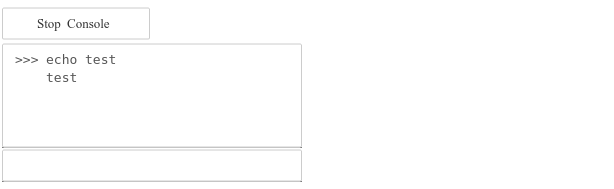

In [5]:
toggle_button = widgets.Button(description="Start Console")
def toggle_console(sender):
    console_container.visible = not console_container.visible
    if console_container.visible:
        toggle_button.description="Stop Console"
        input_box.disabled = False
    else:
        toggle_button.description="Start Console"
toggle_button.on_click(toggle_console)

display(toggle_button)
display(console_container)